# Библиотеки

In [ ]:
!pip install catboost
!pip install missingno

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import hyperopt as opt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import missingno as msno

import catboost as cat
import catboost

SEED = 1
print(catboost.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.24.1


# Данные

In [4]:
!git clone https://github.com/DanilDmitriev1999/competitions

Cloning into 'competitions'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 2), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


Описания колонок из train и test частей:

– "возраст" : возраст клиента

– "профессия" : вид деятельности клиента

– "семейное положение" : семейное положение клиента

– "образование" : уровень образования клиента

– "кредит_дефолт" : имеет ли клиент невыплаченный кредит

– "жилищный_кредит" : имеет ли клиент кредит на жилье или недвижимость в залоге

– "кредит" : имеет ли клиент другие виды кредитов

– "взаимодействие" : по какому типу связи происходило взаимодействие клиента и банка

– "контакт_месяц" : месяц, в котором в последний раз было взаимодействие клиента и банка в рамках текущей маркетинговой кампании

– "контакт_день_недели" : день недели, в котором в последний раз было взаимодействие клиента и банка в рамках текущей маркетинговой кампании

– "контакт_количество" : количество взаимодействий между клиентом и банком за период текущей рекламной кампании

– "контакт_период" : количество дней, прошедших с момента взаимодействия с клиентом в рамках предыдущих рекламных кампаний (999 означает, что с клиентом у банка еще не было взаимодействий)

– "контакт_прошлый_количество" : общее количество контактов между банком и клиентом до текущей рекламной кампании

– "контакт_прошлый_исход" : купил ли клиент услугу в рамках прошлой рекламной кампании

– "контакт_исход" (только для train.csv) : целевая переменная: купил ли клиент услугу в рамках текущей рекламной кампании

In [76]:
train = pd.read_csv('competitions/task_14/marketing_campaign_train.csv', index_col='Id')
train = train.drop('Unnamed: 0', axis=1)
test = pd.read_csv('competitions/task_14/marketing_campaign_test.csv')
test = test.drop('Unnamed: 0', axis=1)

## EDA

In [6]:
train.head()

,возраст,профессия,семейное_положение,образование,кредит_дефолт,жилищный_кредит,кредит,взаимодействие,контакт_месяц,контакт_день_недели,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_прошлый_исход,контакт_исход
Id,,,,,,,,,,,,,,,
0,33,администриратор,не женат/не замужем,специальное,0.0,0.0,0.0,мобильный,5,пн,1,999,1,0,1
1,33,техник/механик,не женат/не замужем,специальное,0.0,1.0,0.0,мобильный,8,ср,1,999,0,-,0
2,30,администриратор,не женат/не замужем,высшее,0.0,1.0,0.0,мобильный,5,пн,1,999,0,-,0
3,31,администриратор,женат/замужем,высшее,0.0,1.0,0.0,домашний,5,пт,2,999,0,-,0
4,31,сфера услуг,не женат/не замужем,среднее,0.0,1.0,0.0,мобильный,5,чт,1,999,0,-,0


## Изучим NaN

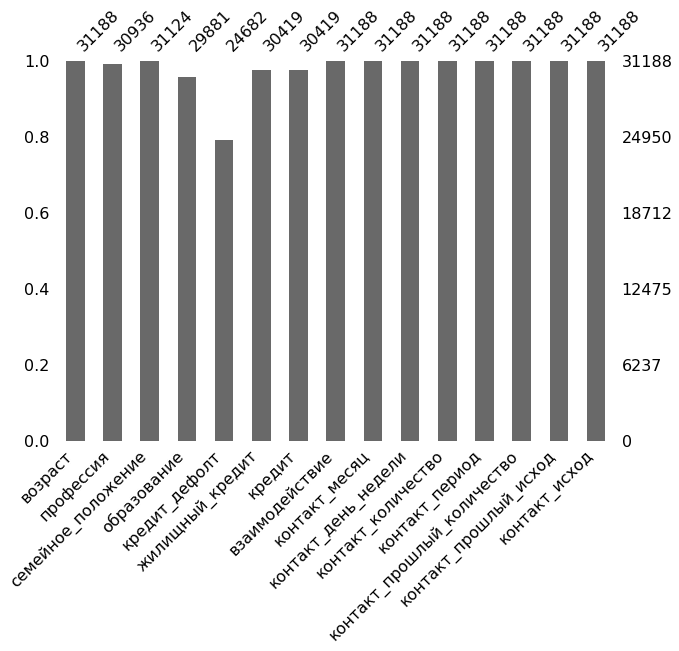

In [7]:
ax = msno.bar(train, figsize=(10, 7))

In [77]:
train.isna().any()

возраст                       False
профессия                      True
семейное_положение             True
образование                    True
кредит_дефолт                  True
жилищный_кредит                True
кредит                         True
взаимодействие                False
контакт_месяц                 False
контакт_день_недели           False
контакт_количество            False
контакт_период                False
контакт_прошлый_количество    False
контакт_прошлый_исход         False
контакт_исход                 False
dtype: bool

Посмотрим распределение данных в пропущенных столбцах

### Профессия

In [12]:
train['профессия'].isnull().sum(), len(train['профессия'])

(252, 31188)

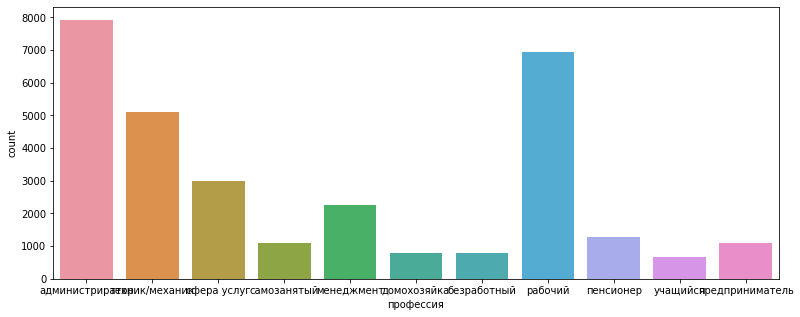

In [19]:
plt.figure(figsize=(13, 5))
sns.countplot(train['профессия'])

### Семейное положение

In [13]:
train['семейное_положение'].isnull().sum(), len(train['семейное_положение'])

(64, 31188)

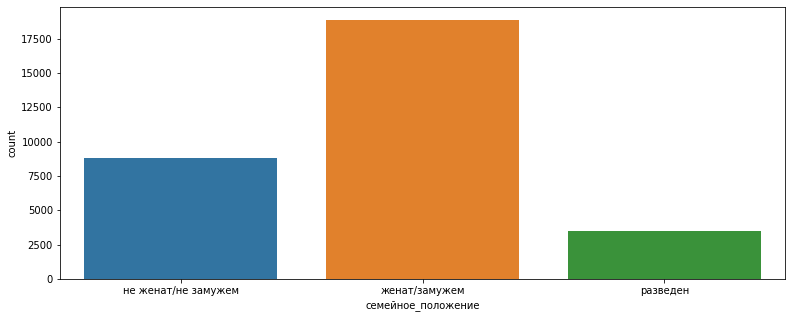

In [20]:
plt.figure(figsize=(13, 5))
sns.countplot(train['семейное_положение'])

### Образование

In [29]:
train['образование'].isnull().sum(), len(train)

(1307, 31188)

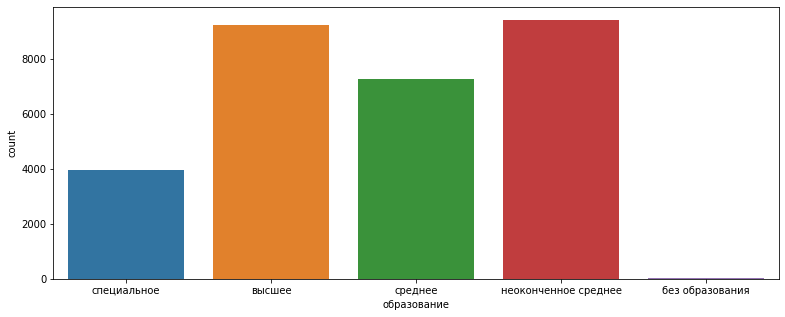

In [18]:
plt.figure(figsize=(13, 5))
sns.countplot(train['образование'])

In [22]:
train['образование'].value_counts()

неоконченное среднее    9414
высшее                  9222
среднее                 7259
специальное             3974
без образования           12
Name: образование, dtype: int64

### кредит_дефолт

In [28]:
train['кредит_дефолт'].isnull().sum(), len(train)

(6506, 31188)

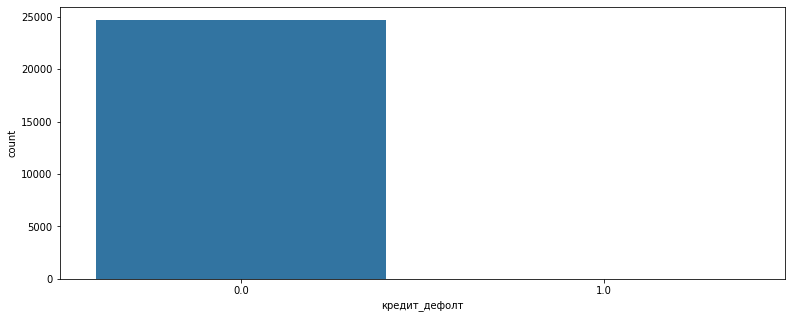

In [24]:
plt.figure(figsize=(13, 5))
sns.countplot(train['кредит_дефолт'])

In [25]:
train['кредит_дефолт'].value_counts()

0.0    24680
1.0        2
Name: кредит_дефолт, dtype: int64

Надо будет его удалить

### желищный_кредит

In [27]:
train['жилищный_кредит'].isnull().sum(), len(train)

(769, 31188)

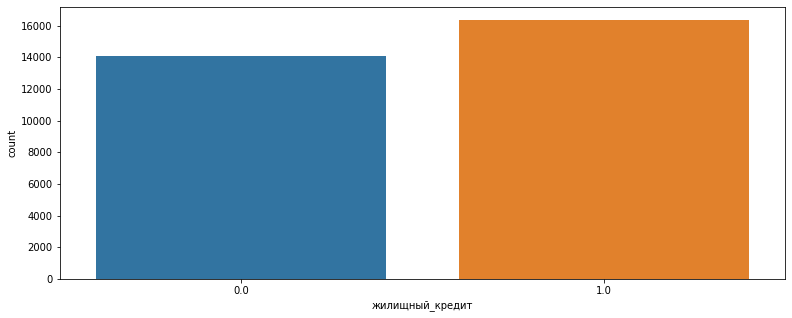

In [31]:
plt.figure(figsize=(13, 5))
sns.countplot(train['жилищный_кредит'])

### Кредит

In [32]:
train['кредит'].isnull().sum(), len(train)

(769, 31188)

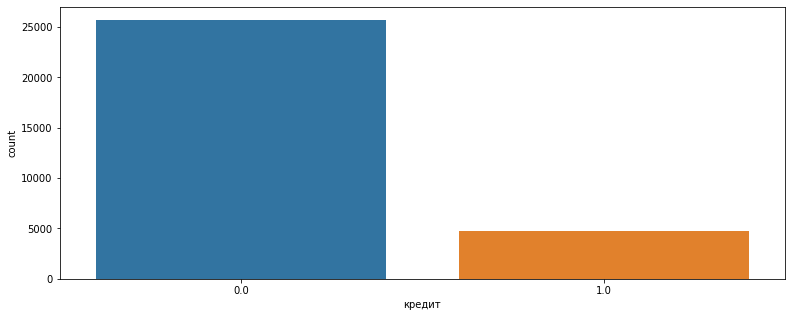

In [33]:
plt.figure(figsize=(13, 5))
sns.countplot(train['кредит'])

Пока удалим ненужный столбец

In [78]:
train = train.drop('кредит_дефолт', axis=1)

## Добавляем столбец-мояк

In [79]:
def add_indicator(col):
    def wrapper(df):
        return df[col].isna().astype(int)
    return wrapper

train = train.assign(cabin_missing_профессия = add_indicator('профессия'))
train = train.assign(cabin_missing_семейное_положение = add_indicator('семейное_положение'))
train = train.assign(cabin_missing_образование = add_indicator('образование'))
train = train.assign(cabin_missing_жилищный_кредит = add_indicator('жилищный_кредит'))
train = train.assign(cabin_missing_кредит = add_indicator('кредит'))

train.head()

,возраст,профессия,семейное_положение,образование,жилищный_кредит,кредит,взаимодействие,контакт_месяц,контакт_день_недели,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_прошлый_исход,контакт_исход,cabin_missing_профессия,cabin_missing_семейное_положение,cabin_missing_образование,cabin_missing_жилищный_кредит,cabin_missing_кредит
Id,,,,,,,,,,,,,,,,,,,
0,33,администриратор,не женат/не замужем,специальное,0.0,0.0,мобильный,5,пн,1,999,1,0,1,0,0,0,0,0
1,33,техник/механик,не женат/не замужем,специальное,1.0,0.0,мобильный,8,ср,1,999,0,-,0,0,0,0,0,0
2,30,администриратор,не женат/не замужем,высшее,1.0,0.0,мобильный,5,пн,1,999,0,-,0,0,0,0,0,0
3,31,администриратор,женат/замужем,высшее,1.0,0.0,домашний,5,пт,2,999,0,-,0,0,0,0,0,0
4,31,сфера услуг,не женат/не замужем,среднее,1.0,0.0,мобильный,5,чт,1,999,0,-,0,0,0,0,0,0


Для модели заменим пропуски на те значения, которых не было в данных

In [85]:
train['профессия'] = train['профессия'].fillna('0')
train['семейное_положение'] = train['семейное_положение'].fillna('0')
train['образование'] = train['образование'].fillna('0')
train['жилищный_кредит'] = train['жилищный_кредит'].fillna(-1)
train['кредит'] = train['кредит'].fillna(-1)

In [44]:
train.shape, test.shape

((31188, 19), (10000, 14))

In [48]:
15

15

In [51]:
train.iloc[:, 0:15].describe()

,возраст,жилищный_кредит,кредит,контакт_месяц,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_исход,cabin_missing_профессия
count,31188.000000,30419.000000,30419.000000,31188.000000,31188.000000,31188.000000,31188.000000,31188.000000,31188.000000
mean,40.004906,0.537855,0.154673,6.613858,2.565570,961.299442,0.175292,0.113633,0.008080
std,10.422822,0.498573,0.361599,2.041405,2.750905,189.789252,0.502301,0.317371,0.089527
min,17.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,5.000000,1.000000,999.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,0.000000,6.000000,2.000000,999.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,0.000000,8.000000,3.000000,999.000000,0.000000,0.000000,0.000000
max,98.000000,1.000000,1.000000,12.000000,56.000000,999.000000,7.000000,1.000000,1.000000


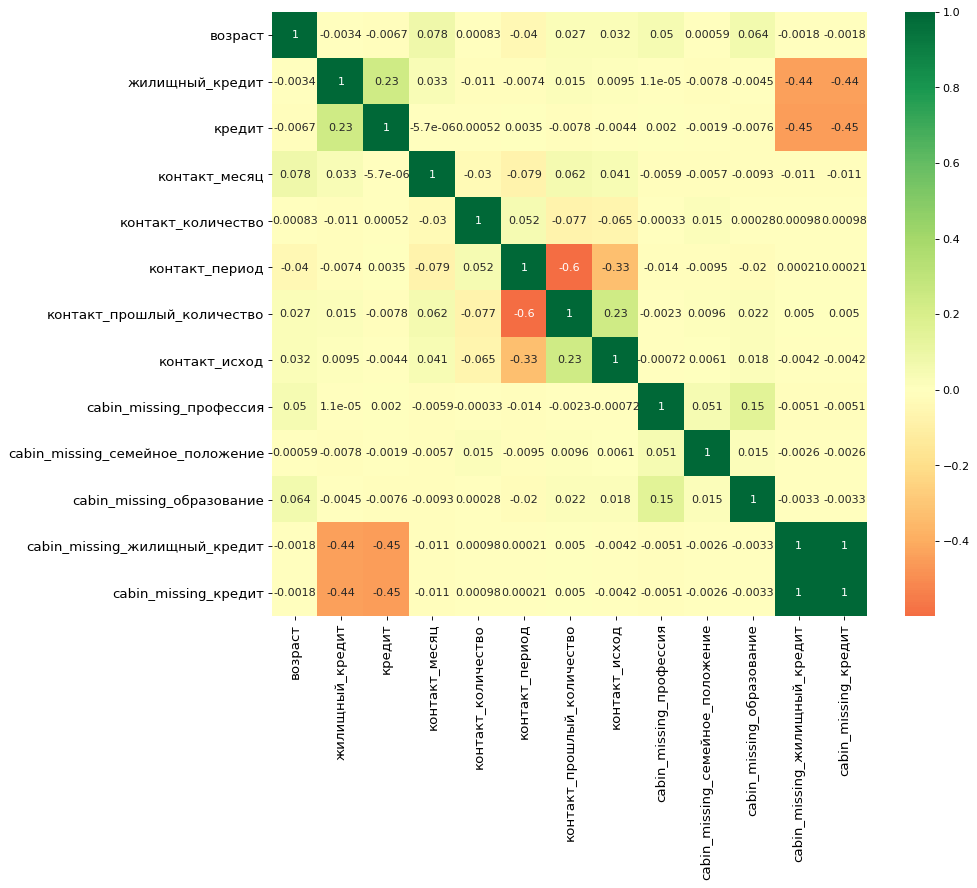

In [87]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr(), cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Как видно, данные не имеют сильной корреляции

Посмотрим на баланс классов:

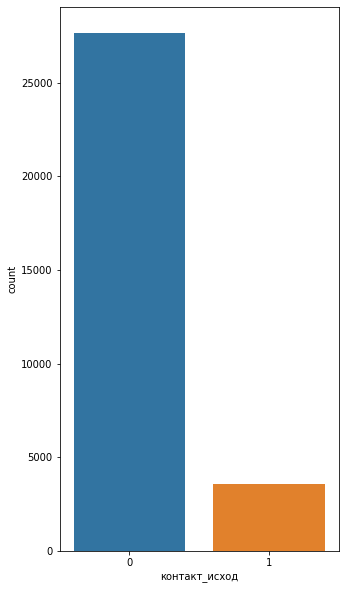

In [ ]:
plt.figure(figsize=(5, 10))
sns.countplot(train['контакт_исход'])

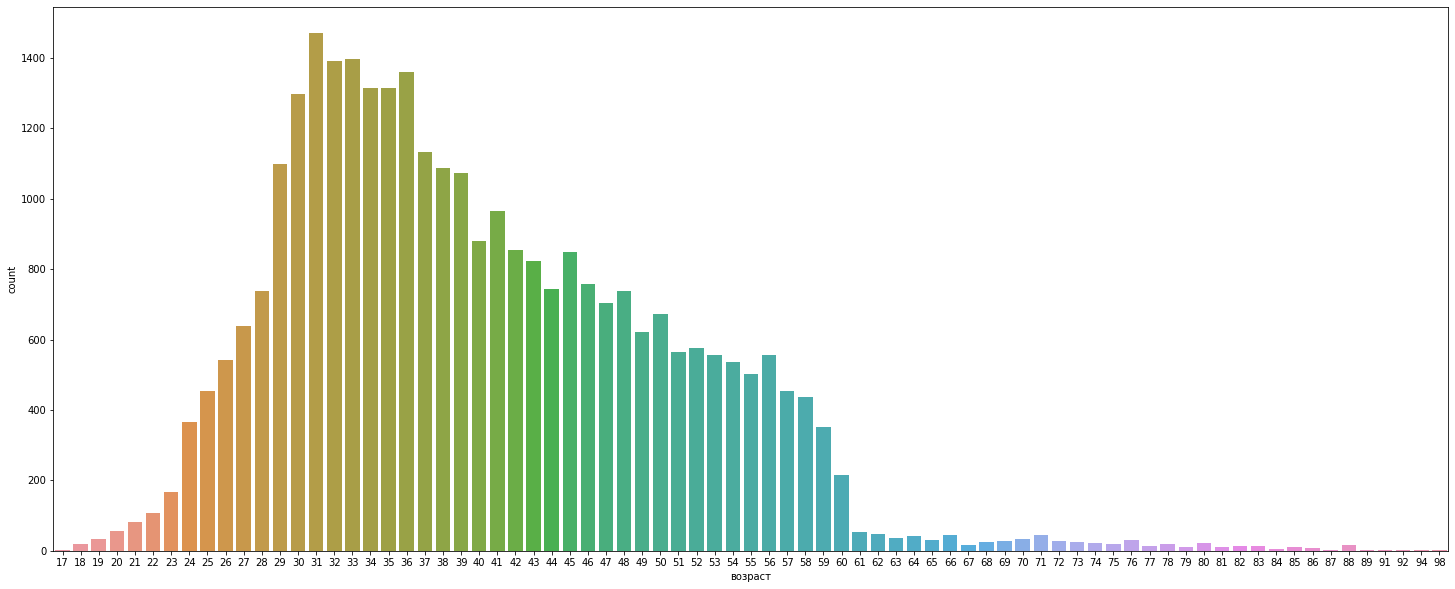

In [ ]:
plt.figure(figsize=(25, 10))
sns.countplot(train['возраст'])

### Что там с категориальными фичами

In [105]:
train.select_dtypes(include=["object_"]).head()

,профессия,семейное_положение,образование,взаимодействие,контакт_день_недели,контакт_прошлый_исход
Id,,,,,,
0,администриратор,не женат/не замужем,специальное,мобильный,пн,0
1,техник/механик,не женат/не замужем,специальное,мобильный,ср,-
2,администриратор,не женат/не замужем,высшее,мобильный,пн,-
3,администриратор,женат/замужем,высшее,домашний,пт,-
4,сфера услуг,не женат/не замужем,среднее,мобильный,чт,-


In [91]:
train['профессия'].value_counts()

администриратор    7924
рабочий            6945
техник/механик     5103
сфера услуг        3004
менеджмент         2258
пенсионер          1290
предприниматель    1085
самозанятый        1082
домохозяйка         793
безработный         778
учащийся            674
0                   252
Name: профессия, dtype: int64

In [92]:
train['семейное_положение'].value_counts()

женат/замужем          18849
не женат/не замужем     8770
разведен                3505
0                         64
Name: семейное_положение, dtype: int64

In [93]:
train['образование'].value_counts()

неоконченное среднее    9414
высшее                  9222
среднее                 7259
специальное             3974
0                       1307
без образования           12
Name: образование, dtype: int64

In [94]:
train['взаимодействие'].value_counts()

мобильный    19819
домашний     11369
Name: взаимодействие, dtype: int64

In [95]:
train['контакт_день_недели'].value_counts()

вт    6471
пн    6428
чт    6158
ср    6143
пт    5988
Name: контакт_день_недели, dtype: int64

In [97]:
train['контакт_прошлый_исход'].value_counts()

-    26911
0     3205
1     1072
Name: контакт_прошлый_исход, dtype: int64

## посмотрим на corr между образованием и профессией

In [70]:
from sklearn.preprocessing import LabelEncoder

In [98]:
gle = LabelEncoder()
genre_labels_1 = gle.fit_transform(train['образование'])
genre_labels_2 = gle.fit_transform(train['профессия'])


In [101]:
np.corrcoef(genre_labels_1, genre_labels_2)

array([[1.        , 0.15405533],
       [0.15405533, 1.        ]])

# catboost

Хороший ноутбук, на тему - [что делать с кагериальные фичами в catboost](https://github.com/catboost/tutorials/blob/master/categorical_features/categorical_features_parameters.ipynb)

## Подготовка к модели

In [ ]:
x_train = train.drop(columns='контакт_исход')
y_train = train['контакт_исход']

X_test = test.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25,
                                                      random_state=SEED, stratify=y_train)

In [ ]:
cat_features_idx = np.where(train.dtypes == 'object')[0].tolist()

In [ ]:
cat_train = cat.Pool(data=X_train, label=y_train, cat_features=cat_features_idx)

cat_val = cat.Pool(data=X_valid, label=y_valid, cat_features=cat_features_idx)

In [ ]:
cat_test = cat.Pool(X_test, cat_features=cat_features_idx)

In [ ]:
params = {'loss_function':'CrossEntropy', 
          'learning_rate':0.1,
          'eval_metric':'F1',
          'verbose': 500,
          'random_seed': SEED,
          'n_estimators':5000,
          'one_hot_max_size':155,
          'max_ctr_complexity': 15,
          "depth":2,
         }

catboost_model_1 = cat.CatBoostClassifier(**params)
catboost_model_1.fit(cat_train, eval_set=cat_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3215995	test: 0.3078231	best: 0.3078231 (0)	total: 19.6ms	remaining: 1m 37s
500:	learn: 0.3619048	test: 0.3115162	best: 0.3196653 (203)	total: 4.9s	remaining: 44s
1000:	learn: 0.3744420	test: 0.3162252	best: 0.3196653 (203)	total: 9.67s	remaining: 38.6s
1500:	learn: 0.3822792	test: 0.3195364	best: 0.3223140 (1492)	total: 14.4s	remaining: 33.6s
2000:	learn: 0.3883171	test: 0.3275720	best: 0.3275720 (2000)	total: 19.6s	remaining: 29.4s
2500:	learn: 0.3953294	test: 0.3278418	best: 0.3297609 (2301)	total: 25.3s	remaining: 25.2s
3000:	learn: 0.4016598	test: 0.3240132	best: 0.3297609 (2301)	total: 31.1s	remaining: 20.7s
3500:	learn: 0.4087148	test: 0.3226863	best: 0.3297609 (2301)	total: 36.8s	remaining: 15.8s
4000:	learn: 0.4088154	test: 0.3224223	best: 0.3297609 (2301)	total: 42.6s	remaining: 10.6s
4500:	learn: 0.4127683	test: 0.3262643	best: 0.3297609 (2301)	total: 49.2s	remaining: 5.45s
4999:	learn: 0.4157489	test: 0.3270952	best: 0.3297609 (2301)	total: 55.5s	remaining: 0us


In [ ]:
params = {'loss_function':'CrossEntropy', 
          'learning_rate':0.03,
          'eval_metric':'F1',
          'verbose': 500,
          'random_seed': SEED,
          'n_estimators':5000,
          'l2_leaf_reg':3,
          'bagging_temperature':1,
          'leaf_estimation_method':'Newton',
          'one_hot_max_size':2,
          'max_ctr_complexity': 15,
          "depth":2,
         }

catboost_model_1 = cat.CatBoostClassifier(**params)
catboost_model_1.fit(cat_train, eval_set=cat_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3220721	test: 0.3078231	best: 0.3078231 (0)	total: 51.8ms	remaining: 4m 18s
500:	learn: 0.3275716	test: 0.3125000	best: 0.3127642 (482)	total: 9.48s	remaining: 1m 25s
1000:	learn: 0.3454290	test: 0.3134954	best: 0.3187919 (797)	total: 19.9s	remaining: 1m 19s
1500:	learn: 0.3466968	test: 0.3066554	best: 0.3187919 (797)	total: 30.4s	remaining: 1m 10s
2000:	learn: 0.3496898	test: 0.3018550	best: 0.3187919 (797)	total: 41.8s	remaining: 1m 2s
2500:	learn: 0.3567811	test: 0.3046025	best: 0.3187919 (797)	total: 53.5s	remaining: 53.4s


KeyboardInterrupt: ignored

0.33

Recall: 0.21

Precision: 0.65

In [ ]:
cat_train = cat.Pool(data=train.drop(columns='контакт_исход'),
                     label=train['контакт_исход'],
                     cat_features=cat_features_idx)

params = {'loss_function':'CrossEntropy', 
          'learning_rate':0.1,
          'eval_metric':'F1',
          'verbose': 500,
          'random_seed': SEED,
          'n_estimators':5000,
          'one_hot_max_size':155,
          'max_ctr_complexity': 10,
          "depth":2,
         }

catboost_model_1 = cat.CatBoostClassifier(**params)
catboost_model_1.fit(cat_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3028596	total: 19.4ms	remaining: 1m 37s


KeyboardInterrupt: ignored

# сабмит

In [ ]:
predict = catboost_model_1.predict(cat_test)

In [ ]:
my_submit = pd.DataFrame({'Out': predict})
my_submit.head()

,Out
0,0
1,0
2,0
3,0
4,1


In [ ]:
my_submit['Out'].value_counts()

0    9647
1     353
Name: Out, dtype: int64

In [ ]:
my_submit.to_csv('baseline2.csv', index=False)

In [ ]:
print()

# LightGBM

Сначала попробуем все категориальные признаки onehotencoder сделать

## OneHotEncoder

In [104]:
train.head(2)

,возраст,профессия,семейное_положение,образование,жилищный_кредит,кредит,взаимодействие,контакт_месяц,контакт_день_недели,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_прошлый_исход,контакт_исход,cabin_missing_профессия,cabin_missing_семейное_положение,cabin_missing_образование,cabin_missing_жилищный_кредит,cabin_missing_кредит
Id,,,,,,,,,,,,,,,,,,,
0,33,администриратор,не женат/не замужем,специальное,0.0,0.0,мобильный,5,пн,1,999,1,0,1,0,0,0,0,0
1,33,техник/механик,не женат/не замужем,специальное,1.0,0.0,мобильный,8,ср,1,999,0,-,0,0,0,0,0,0


In [107]:
a = pd.get_dummies(train['профессия'], prefix = "профессия")
b = pd.get_dummies(train['семейное_положение'], prefix = "семейное_положение")
c = pd.get_dummies(train['образование'], prefix = "образование")
d = pd.get_dummies(train['взаимодействие'], prefix = "взаимодействие")
e = pd.get_dummies(train['контакт_день_недели'], prefix = "контакт_день_недели")
f = pd.get_dummies(train['контакт_прошлый_исход'], prefix = "контакт_прошлый_исход")

In [108]:
frames = [train, a, b, c, d, e, f]
ohe_train = pd.concat(frames, axis = 1)
ohe_train = ohe_train.drop(columns = ['профессия', 'семейное_положение', 'образование',
                                      'взаимодействие', 'контакт_день_недели',
                                      'контакт_прошлый_исход'])

ohe_train.head()

,возраст,жилищный_кредит,кредит,контакт_месяц,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_исход,cabin_missing_профессия,cabin_missing_семейное_положение,cabin_missing_образование,cabin_missing_жилищный_кредит,cabin_missing_кредит,профессия_0,профессия_администриратор,профессия_безработный,профессия_домохозяйка,профессия_менеджмент,профессия_пенсионер,профессия_предприниматель,профессия_рабочий,профессия_самозанятый,профессия_сфера услуг,профессия_техник/механик,профессия_учащийся,семейное_положение_0,семейное_положение_женат/замужем,семейное_положение_не женат/не замужем,семейное_положение_разведен,образование_0,образование_без образования,образование_высшее,образование_неоконченное среднее,образование_специальное,образование_среднее,взаимодействие_домашний,взаимодействие_мобильный,контакт_день_недели_вт,контакт_день_недели_пн,контакт_день_недели_пт,контакт_день_недели_ср,контакт_день_недели_чт,контакт_прошлый_исход_-,контакт_прошлый_исход_0,контакт_прошлый_исход_1
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,33,0.0,0.0,5,1,999,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
1,33,1.0,0.0,8,1,999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
2,30,1.0,0.0,5,1,999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
3,31,1.0,0.0,5,2,999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
4,31,1.0,0.0,5,1,999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0


### Модель

In [151]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [149]:
ohe_train_1 = ohe_train.drop(['cabin_missing_профессия', 'cabin_missing_семейное_положение', 'cabin_missing_образование',
                              'cabin_missing_жилищный_кредит', 'cabin_missing_кредит'], axis=1)

In [152]:
X = ohe_train_1.drop(['контакт_исход'], axis=1)
y = ohe_train_1['контакт_исход']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_valid, label=y_valid)

In [153]:
# X = ohe_train.drop(['контакт_исход'], axis=1)
# y = ohe_train['контакт_исход']

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_valid, label=y_valid)

params = {
        "objective" : "binary",
        'metric':"None",
        'max_depth':20,
        "num_leaves" : 10,
        'min_data_in_leaf':15,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "verbosity" : -1,
        'importance_type':'gain',
        "seed": 42
    }

lgr = lgb.train(params, train_data, 3500,
                valid_sets=[train_data, test_data],
                verbose_eval=500, feval=lgb_f1_score)

pred_test_y = lgr.predict(X_valid, num_iteration=lgr.best_iteration)
pred_test_y = np.round(pred_test_y)

print('-'*100)
print('F1-score = {:.2%}'.format(f1_score(y_valid, pred_test_y)))

[500]	training's f1: 0.336656	valid_1's f1: 0.335279
[1000]	training's f1: 0.360259	valid_1's f1: 0.334992
[1500]	training's f1: 0.381271	valid_1's f1: 0.330864
[2000]	training's f1: 0.391437	valid_1's f1: 0.336601
[2500]	training's f1: 0.403751	valid_1's f1: 0.335778
[3000]	training's f1: 0.416026	valid_1's f1: 0.333063
[3500]	training's f1: 0.427439	valid_1's f1: 0.337914
----------------------------------------------------------------------------------------------------
F1-score = 33.79%


Рекорд: 34.33%
```
params = {
        "objective" : "binary",
        'metric':"None",
        'max_depth':20,
        "num_leaves" : 10,
        'min_data_in_leaf':15,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "verbosity" : -1,
        'importance_type':'gain',
        "seed": 42
    }
```



### submit

In [154]:
test = pd.read_csv('competitions/task_14/marketing_campaign_test.csv')
test = test.drop('Unnamed: 0', axis=1)

test = test.drop('кредит_дефолт', axis=1)

# test = test.assign(cabin_missing_профессия = add_indicator('профессия'))
# test = test.assign(cabin_missing_семейное_положение = add_indicator('семейное_положение'))
# test = test.assign(cabin_missing_образование = add_indicator('образование'))
# test = test.assign(cabin_missing_жилищный_кредит = add_indicator('жилищный_кредит'))
# test = test.assign(cabin_missing_кредит = add_indicator('кредит'))

test['профессия'] = test['профессия'].fillna('0')
test['семейное_положение'] = test['семейное_положение'].fillna('0')
test['образование'] = test['образование'].fillna('0')
test['жилищный_кредит'] = test['жилищный_кредит'].fillna(-1)
test['кредит'] = test['кредит'].fillna(-1)

a = pd.get_dummies(test['профессия'], prefix = "профессия")
b = pd.get_dummies(test['семейное_положение'], prefix = "семейное_положение")
c = pd.get_dummies(test['образование'], prefix = "образование")
d = pd.get_dummies(test['взаимодействие'], prefix = "взаимодействие")
e = pd.get_dummies(test['контакт_день_недели'], prefix = "контакт_день_недели")
f = pd.get_dummies(test['контакт_прошлый_исход'], prefix = "контакт_прошлый_исход")

frames = [test, a, b, c, d, e, f]
test = pd.concat(frames, axis = 1)
test = test.drop(columns = ['профессия', 'семейное_положение', 'образование',
                                      'взаимодействие', 'контакт_день_недели',
                                      'контакт_прошлый_исход'])

test.head()

,возраст,жилищный_кредит,кредит,контакт_месяц,контакт_количество,контакт_период,контакт_прошлый_количество,профессия_0,профессия_администриратор,профессия_безработный,профессия_домохозяйка,профессия_менеджмент,профессия_пенсионер,профессия_предприниматель,профессия_рабочий,профессия_самозанятый,профессия_сфера услуг,профессия_техник/механик,профессия_учащийся,семейное_положение_0,семейное_положение_женат/замужем,семейное_положение_не женат/не замужем,семейное_положение_разведен,образование_0,образование_без образования,образование_высшее,образование_неоконченное среднее,образование_специальное,образование_среднее,взаимодействие_домашний,взаимодействие_мобильный,контакт_день_недели_вт,контакт_день_недели_пн,контакт_день_недели_пт,контакт_день_недели_ср,контакт_день_недели_чт,контакт_прошлый_исход_-,контакт_прошлый_исход_0,контакт_прошлый_исход_1
0,30,1.0,0.0,11,1,999,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,30,1.0,0.0,8,12,999,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0
2,36,0.0,0.0,5,1,999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,47,0.0,0.0,4,1,999,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
4,64,0.0,0.0,6,1,999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0


модель на полных обучаемых данных:

In [158]:
train_data = lgb.Dataset(ohe_train_1.drop(['контакт_исход'], axis=1),
                         label=ohe_train_1['контакт_исход'])

params = {
        "objective" : "binary",
        'metric':"None",
        'max_depth':20,
        "num_leaves" : 10,
        'min_data_in_leaf':25,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "verbosity" : -1,
        'importance_type':'gain',
        "seed": 42
    }

lgr = lgb.train(params, train_data, 3500,
                valid_sets=[train_data],
                verbose_eval=500, feval=lgb_f1_score)

[500]	training's f1: 0.332264
[1000]	training's f1: 0.352297
[1500]	training's f1: 0.364095
[2000]	training's f1: 0.375131
[2500]	training's f1: 0.381529
[3000]	training's f1: 0.386936
[3500]	training's f1: 0.394944


In [159]:
pred_test_y = lgr.predict(test, num_iteration=lgr.best_iteration)
pred_test_y = np.round(pred_test_y)
pred_test_y = [int(i) for i in pred_test_y]

my_submit = pd.DataFrame({'Out': pred_test_y})
my_submit.head()

,Out
0,0
1,0
2,0
3,0
4,1


In [160]:
my_submit.to_csv('baseline3.csv', index=False)

Result: 2.93